In [241]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

True


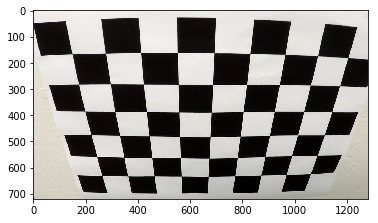

In [242]:
img = mpimg.imread("./camera_cal/calibration2.jpg")
plt.imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
print(ret)

In [243]:
image_locs = glob.glob("./camera_cal/calibration*.jpg")
objpoints = []
imgpoints = []

images = []

for image_loc in image_locs:
    img = mpimg.imread(image_loc)
    images.append(img)

objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

for frame in images:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        cv2.drawChessboardCorners(frame, (9,6), corners, ret)
        #plt.imshow(img)
        
        
ret, mtx, dist,rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)



In [244]:
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


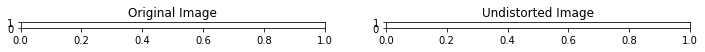

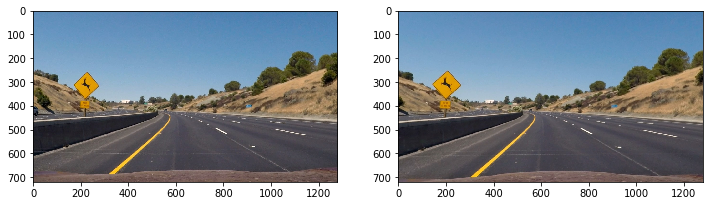

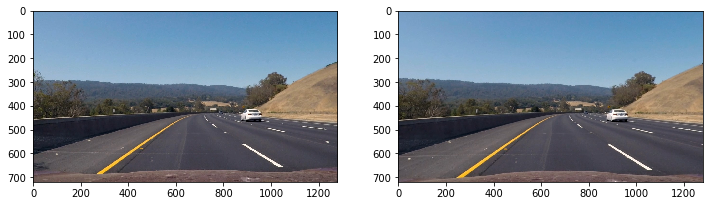

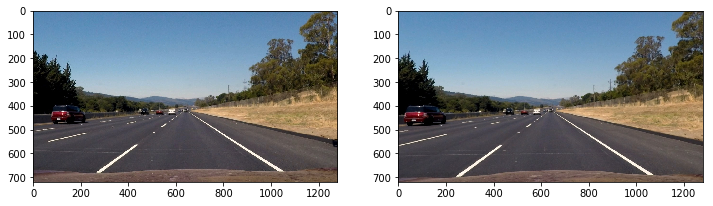

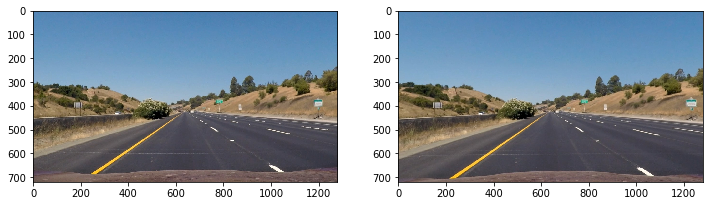

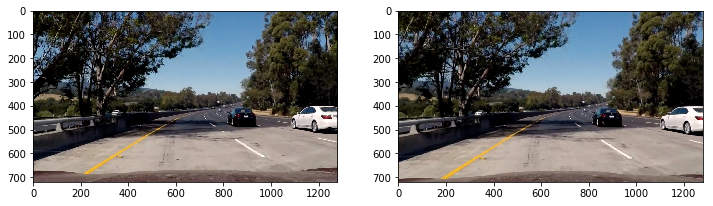

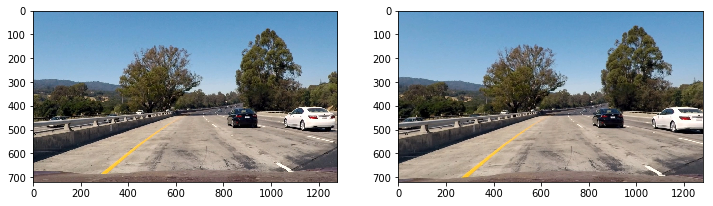

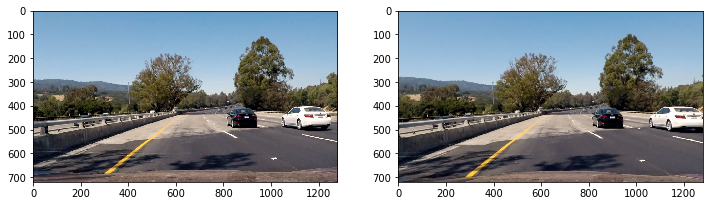

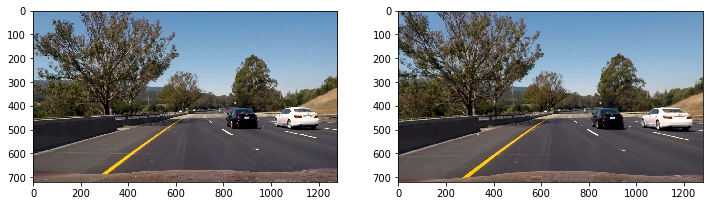

In [245]:
test_image_locs = glob.glob("./test_images/*.jpg")
_, arr = plt.subplots(1,2,figsize=(12,0.1))
arr[0].set_title("Original Image")
arr[1].set_title("Undistorted Image")

for test_image_loc in test_image_locs:
    test_image=mpimg.imread(test_image_loc)
    dist_test_image=undistort(test_image)
    _, arr = plt.subplots(1,2, figsize=(12,6))
    arr[0].imshow(test_image)
    arr[1].imshow(dist_test_image)

In [258]:
def top_view(img):
    
    src_points = np.float32([ [450, 520],
                              [850, 520],
                              [1250, 720],
                              [40, 720]])
    dst_points = np.float32([ [0,0],
                              [1280,0],
                              [1250,720],
                              [40,720]])
    '''
       src_points = np.float32([ [491, 480],
                              [809, 480],
                              [1250, 720],
                              [40, 720]])
    dst_points = np.float32([ [0,0],
                              [1280,0],
                              [1250,720],
                              [40,720]])'''
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    MInv = cv2.getPerspectiveTransform(dst_points, src_points)
    top_view_image = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return top_view_image, MInv

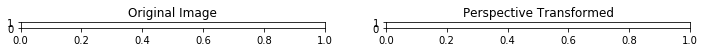

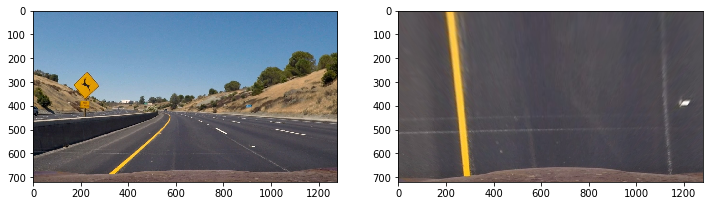

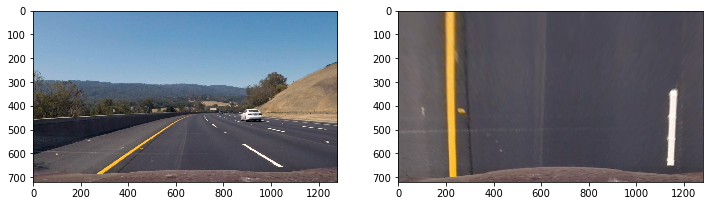

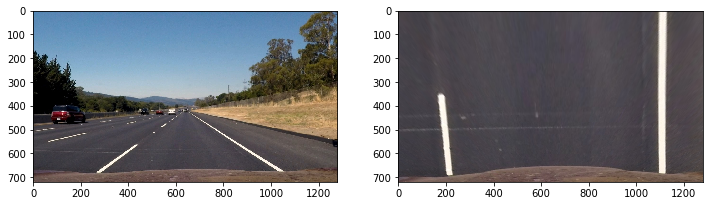

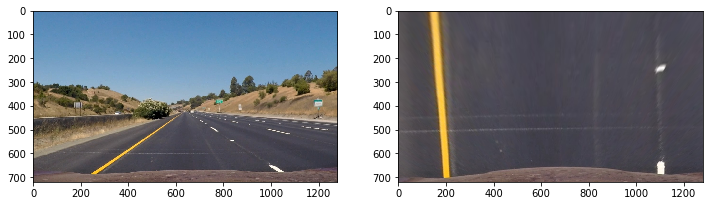

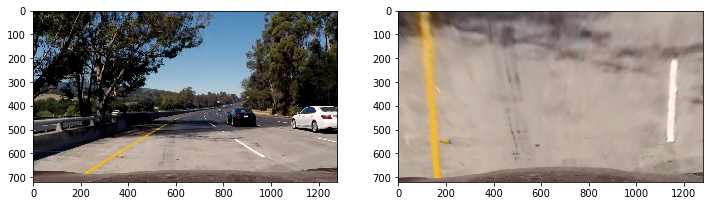

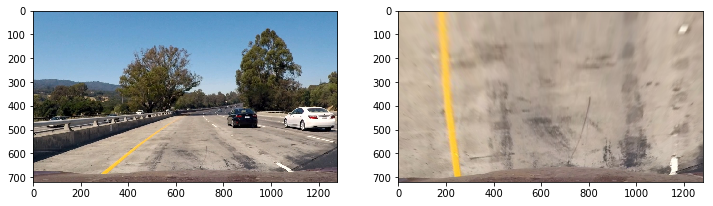

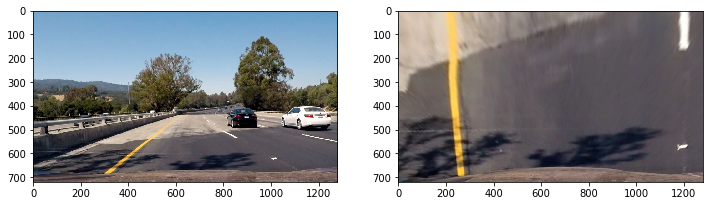

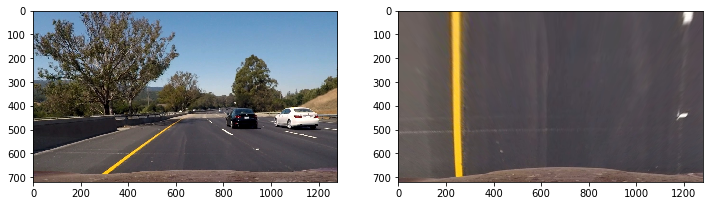

In [259]:
test_image_locs = glob.glob("./test_images/*.jpg")
_, arr = plt.subplots(1,2,figsize=(12,0.1))
arr[0].set_title("Original Image")
arr[1].set_title("Perspective Transformed")

for test_image_loc in test_image_locs:
    test_image=mpimg.imread(test_image_loc)
    dist_test_image=undistort(test_image)
    top_view_image, _ = top_view(dist_test_image)
    _, arr = plt.subplots(1,2, figsize=(12,6))
    arr[0].imshow(test_image)
    arr[1].imshow(top_view_image)

In [260]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    '''
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    #threshold x gradient
    sobel_grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobel_x = np.absolute(sobel_grad_x)
    abs_sobel_y = np.absolute(sobel_grad_y)

    direction = np.absolute(np.arctan2(abs_sobel_y,abs_sobel_x))
   
    binary_grad = np.zeros_like(direction)
    binary_grad[(direction >= 0) & (direction <= np.pi/2)] = 1

    combined_sobel = ((sxbinary == 1) & (binary_grad == 1))
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    
    rg_binary = np.zeros_like(r_channel)
    rg_binary = ((r_channel >50) & (g_channel > 50))
    
    combined_color = ((rg_binary == 1) | (combined_sobel == 1))
 
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(combined_color == 1) & (combined_sobel == 1)] = 1
    return combined_binary
    '''

In [261]:
def get_binary_image(image):
    dist_test_image=undistort(image)
    top_view_image, MInv = top_view(dist_test_image)
    binary_image = pipeline(top_view_image)
    return binary_image, MInv, top_view

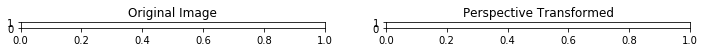

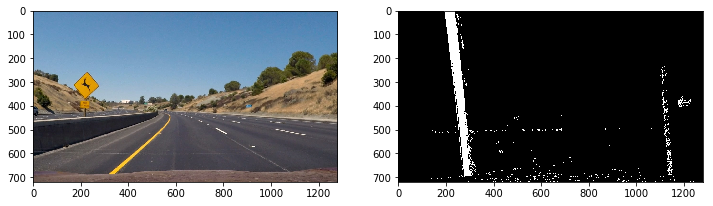

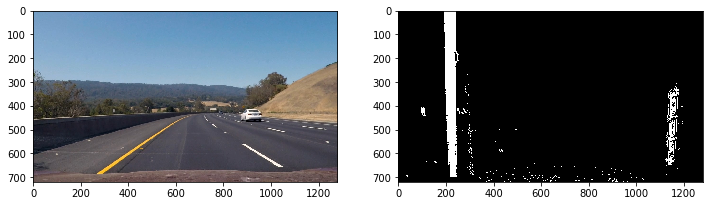

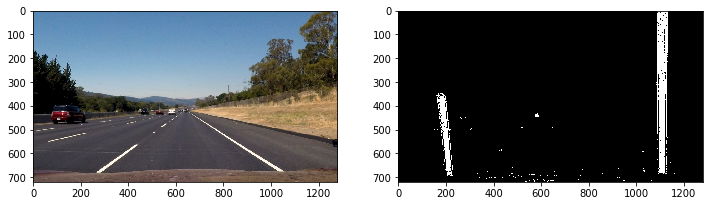

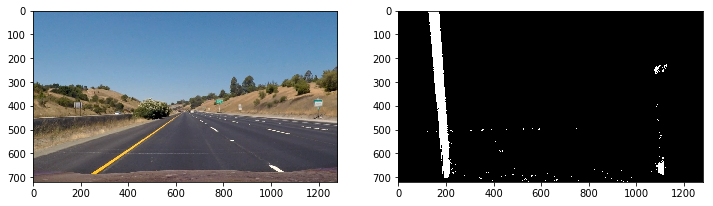

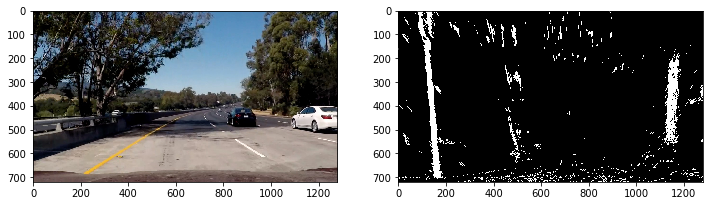

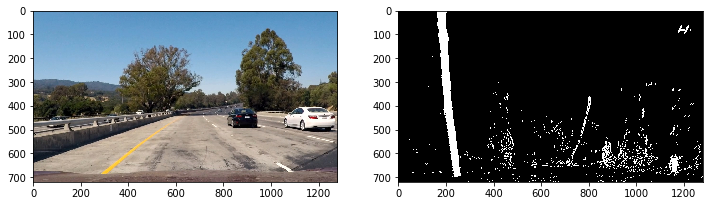

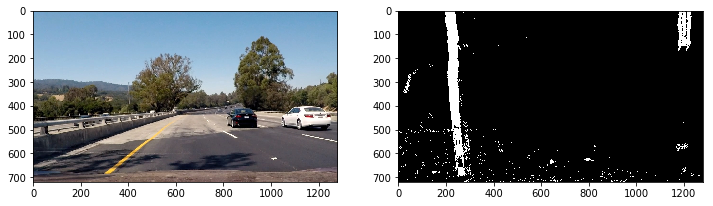

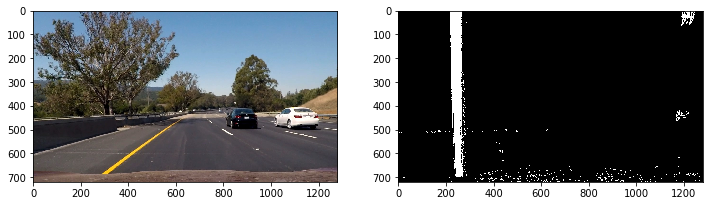

In [262]:
test_image_locs = glob.glob("./test_images/*.jpg")
_, arr = plt.subplots(1,2,figsize=(12,0.1))
arr[0].set_title("Original Image")
arr[1].set_title("Perspective Transformed")

for test_image_loc in test_image_locs:
    test_image=mpimg.imread(test_image_loc)
    binary_image, _ , _= get_binary_image(test_image)
    _, arr = plt.subplots(1,2, figsize=(12,6))
    arr[0].imshow(test_image)
    arr[1].imshow(binary_image, cmap="gray")

In [263]:
# find_window_centroids is function showin in lecture #23
def find_window_centroids(binary_warped, nwindows, margin, display):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0] / 2):, :], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
        nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
        nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #if display == True:
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #print(left_fitx[0])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        #plt.imshow(out_img)
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)

    return left_fit, right_fit, out_img, left_fitx, right_fitx, ploty

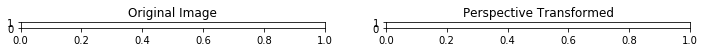

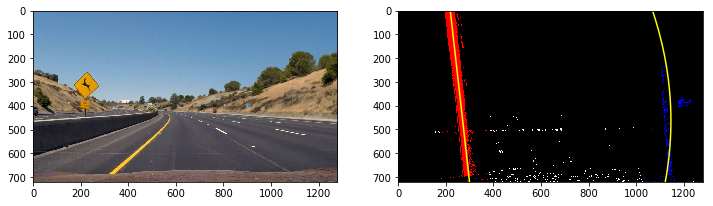

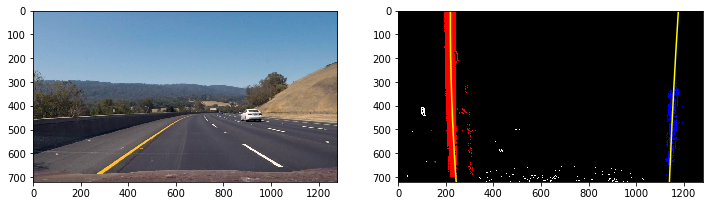

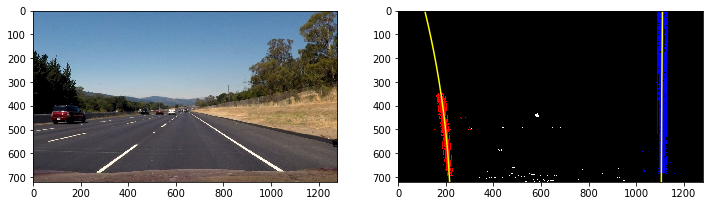

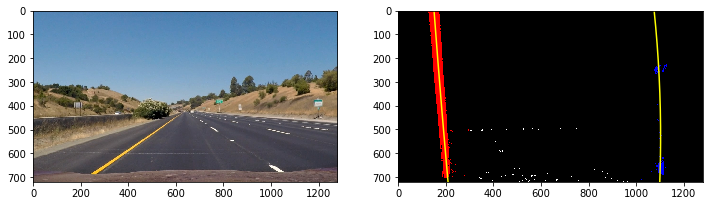

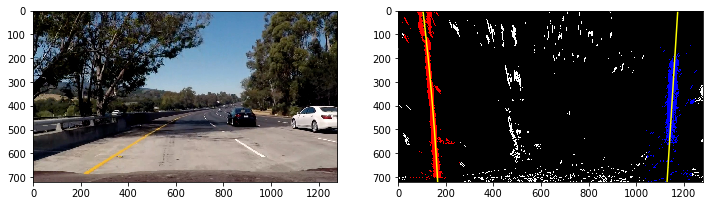

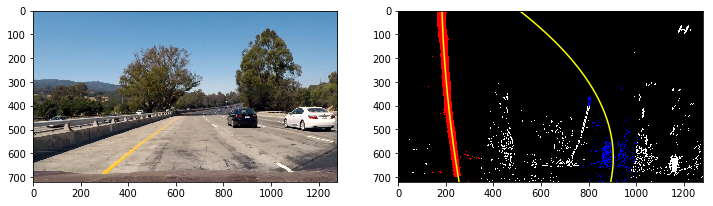

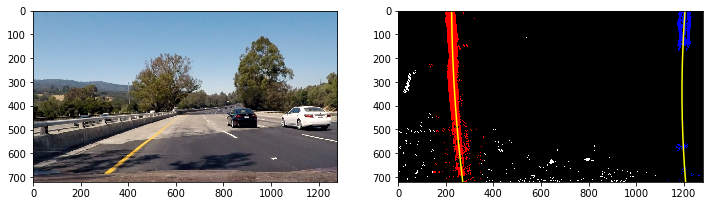

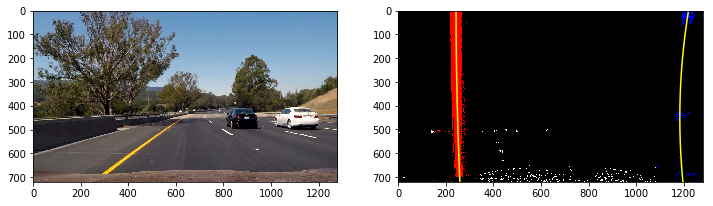

In [264]:
test_image_locs = glob.glob("./test_images/*.jpg")
_, arr = plt.subplots(1,2,figsize=(12,0.1))
arr[0].set_title("Original Image")
arr[1].set_title("Perspective Transformed")

for test_image_loc in test_image_locs:
    test_image=mpimg.imread(test_image_loc)
    binary_image,_, _ = get_binary_image(test_image)
    left_fit, right_fit, out_img, left_fitx, right_fitx, ploty =find_window_centroids(binary_image, 9,100, True)
    
    _, arr = plt.subplots(1,2, figsize=(12,6))
    arr[0].imshow(test_image)
    arr[1].imshow(out_img, cmap="gray")
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    

In [265]:
def skip_sliding_window(binary_warped, left_fit, right_fit):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, out_img, left_fitx, right_fitx, ploty

In [266]:
class Lane():

    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # recent values of the last n fits of the line
        self.recent_fits = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        self.prev_x = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.last_good_curvature = None
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None
        # x values in windows
        self.windows = np.ones((3, 12)) * -1


In [298]:
class optimized_lane_finder:
    def __init__(self):
        self.left_lane = Lane()
        self.right_lane = Lane()
        self.mean_frames = 20
        
    def sanity_check(self, left_fitx, right_fitx, left_cur, right_cur):
        
        diff = (left_cur - right_cur)
        '''
        if self.left_lane.last_good_curvature != None:
            if (not self.left_lane.prev_x is None) and (not self.right_lane.prev_x is None):
                if left_cur > 1000 or right_cur > 1000:

                        print("return prev")
                        left_cur = self.left_lane.radius_of_curvature
                        right_cur = self.right_lane.radius_of_curvature
                        left_cur = self.left_lane.last_good_curvature
                        right_cur = self.right_lane.last_good_curvature 
                        return self.left_lane.prev_x, self.right_lane.prev_x, left_cur, right_cur
            else:
                if left_cur < 1000 and right_cur < 1000:
                    self.left_lane.prev_x = left_fitx
                    self.right_lane.prev_x = right_fitx
                    self.left_lane.last_good_curvature = left_cur
                    self.right_lane.last_good_curvature = right_cur
        '''
        if (not left_fitx is None) and (not right_fitx is None):
            if (diff < 5000) and abs(diff) < 5000 and (right_cur > 500):

                    self.left_lane.prev_x = left_fitx
                    self.right_lane.prev_x = right_fitx
                    self.left_lane.last_good_curvature = left_cur
                    self.right_lane.last_good_curvature = right_cur
            else:
                if (not self.left_lane.prev_x is None) and (not self.right_lane.prev_x is None):
                    #print("return new")
                    return self.left_lane.prev_x, self.right_lane.prev_x, self.left_lane.last_good_curvature, self.right_lane.last_good_curvature
            ret_left = left_fitx
            ret_right = right_fitx
        
        #self.left_lane.radius_of_curvature = left_cur
        #self.right_lane.radius_of_curvature = right_cur
        
        if left_fitx is None:
            if len(self.left_lane.recent_fits) == 0:
                ret_left = left_fitx
            else:
                ret_left =  self.left_lane.recent_fits[-1]
        else:
            if len(self.left_lane.recent_fits) < self.mean_frames:
                self.left_lane.recent_fits.append(left_fitx)
            else:
                self.left_lane.recent_fits[0:self.mean_frames-1] = self.left_lane.recent_fits[1:]
                self.left_lane.recent_fits[self.mean_frames-1] = left_fitx
                new_left_x = np.zeros_like(left_fitx)
                for i in range(self.mean_frames):
                    new_left_x += self.left_lane.recent_fits[i]

                new_left_x /= self.mean_frames
                
                ret_left = new_left_x
                
        if right_fitx is None:
            if len(self.right_lane.recent_fits) == 0:
                ret_right = right_fitx
            else:
                ret_right =  self.right_lane.recent_fits[-1]
        else:
            if len(self.right_lane.recent_fits) < self.mean_frames:
                self.right_lane.recent_fits.append(right_fitx)
            else:
                self.right_lane.recent_fits[0:self.mean_frames-1] = self.right_lane.recent_fits[1:]
                self.right_lane.recent_fits[self.mean_frames-1] = right_fitx
                new_right_x = np.zeros_like(right_fitx)
                for i in range(self.mean_frames):
                    new_right_x += self.right_lane.recent_fits[i]

                new_right_x /= self.mean_frames
                
                ret_right = new_right_x
        
        return ret_left, ret_right, left_cur,right_cur
        
    def calc_lanes(self, binary):
        #if self.left_lane.detected and self.right_lane.detected:
        #    left_fit, right_fit, out_img, left_fitx, right_fitx, ploty = \
        #    skip_sliding_window(binary, self.left_lane.best_fit, self.right_lane.best_fit)
        #else:
        left_fit, right_fit, out_img, left_fitx, right_fitx, ploty = \
        find_window_centroids(binary, 8, 100, True)
          
        #calculate curvature, code from Udacity y, fitx
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        # assume the lane is about 30 meters long and 3.7 meters wide
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        left_fitx,right_fitx,left_curverad ,right_curverad = self.sanity_check(left_fitx, right_fitx, left_curverad, right_curverad)
             
        return left_fitx, right_fitx, left_curverad, right_curverad, ploty
    
    def get_position(self, pts, image_shape = (720, 1280)):

        #  Find the position of the car from the center
        # It will show if the car is 'x' meters from the left or right

        position = image_shape[1]/2
        left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
        right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
        center = (left + right)/2

        xm_per_pix = 3.7/700 
        return (position - center)*xm_per_pix
    
    def draw_poly(self, image, warped, yvals, left_fitx, right_fitx, Minv, curvature, right_curverad, top_view):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        #print(np.array(left_fitx).shape)
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        # Put text on an image"
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = "Radius of Curvature: {} m".format(int(curvature))
        cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)

        text = "Radius of right Curvature: {} m".format(int(right_curverad))
        cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
        
        pts = np.argwhere(newwarp[:,:,1])
        position = abs(self.get_position(pts))
        text = "Vehicle is {:.2f} m right of center".format(position)
        cv2.putText(result,text,(400,200), font, 1,(255,255,255),2)
        return result

    def process_image(self, image):

        binary, MInv, top_view = get_binary_image(image)
        left_fitx, right_fitx, left_curverad, right_curverad, ploty = self.calc_lanes(binary)        
        return self.draw_poly(image, binary, ploty, left_fitx, right_fitx, MInv, left_curverad, right_curverad, top_view)

    
    

In [299]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


lf = optimized_lane_finder()
output = 'output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lf.process_image)  # NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output2.mp4
[MoviePy] Writing video output2.mp4



 12%|█▏        | 152/1261 [00:31<04:15,  4.34it/s]


 24%|██▍       | 303/1261 [01:27<03:17,  4.85it/s]


 36%|███▌      | 454/1261 [01:56<02:37,  5.11it/s]


 48%|████▊     | 605/1261 [02:34<03:02,  3.59it/s]


 60%|█████▉    | 756/1261 [03:07<01:36,  5.22it/s]


 72%|███████▏  | 907/1261 [03:37<01:09,  5.07it/s]


 84%|████████▍ | 1057/1261 [04:12<01:01,  3.31it/s]


 96%|█████████▌| 1206/1261 [04:45<00:10,  5.04it/s]


100%|█████████▉| 1260/1261 [04:55<00:00,  5.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output2.mp4 

CPU times: user 7min 11s, sys: 18.2 s, total: 7min 30s
Wall time: 4min 57s
